# Term Project: Housing Prices Competition for Kaggle Learn Users

### Competition Description
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.


### Goal
It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 


### Metric
Submissions are evaluated on ***Root-Mean-Squared-Error (RMSE)*** between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

In [3]:
# --- Setup, Imports, และ Data Loading ---

# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ML Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Load the datasets
try:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    sample_submission = pd.read_csv('sample_submission.csv')
    print("train.csv, test.csv, and sample_submission.csv loaded successfully ")
except FileNotFoundError:
    print("!!! ERROR: CSV files not found !!!")
    print("Please ensure 'train.csv', 'test.csv', and 'sample_submission.csv' are in the same directory.")

# Store test set 'Id' for submission
test_ids = test_df['Id']

# Set the default style for plots
sns.set(style="whitegrid")

train.csv, test.csv, and sample_submission.csv loaded successfully 


## EDA and Handling the Target Variable (SalePrice)

Before we can build a model, we must first understand our data. This process is called ***Exploratory Data Analysis (EDA)***.

The most important column in our entire dataset is `SalePrice`. This is the **Target Variable**—the single thing we are trying to predict.

**Why Look at This Before Modeling?**
We need to understand the shape and characteristics of our target. If we just feed raw data into a model, we will get bad results. We are looking for two main things:

1. **The Distribution:** What do the house prices look like? Are they evenly spread out, or are most of them cheap?

2. **Key Relationships:** Which other features (like `GrLivArea` or `OverallQual`) seem to have the biggest impact on the price?

**What We Look For (The Histogram)**
We use a Histogram to see the "shape" of the `SalePrice` data.

- **The Problem: "Skew"** When we plot the original `SalePrice`, we see it is **"Right-Skewed"**. This means most houses are in the low-to-medium price range, with a few very expensive houses pulling the average up.

- **Why This Is Bad for ML:** Models like Linear Regression and Neural Networks get confused by this. They become very good at predicting the "average" houses but will be terrible at predicting the rare, expensive ones.

**The Solution: Log-Transform**
- **The Technique:** To fix this, we apply a mathematical function called a **Log Transform** (`np.log1p()`).

- **What It Does:** This function "compresses" the large values more than the small values. It pulls the long "tail" of expensive houses back in, making the shape look much more like a symmetrical "bell curve" (a Normal Distribution).

- **The Result:** Our model will now train on this "fixed" data, allowing it to learn the patterns for both cheap and expensive houses much more effectively.

(This is why our code runs `np.log1p()` **ONCE** on the `SalePrice` column. We must also remember to reverse this process using `np.expm1()` at the very end to turn our model's log-prediction back into a real dollar price.)

**What We Look For (The Correlation Heatmap)**
We also create a **Correlation Heatmap**. This tells us which features are most strongly related to `SalePrice`.

- A high positive number (e.g., +`0.8`) means "As this feature goes up, the SalePrice goes up."

- This heatmap is what we use for Feature Selection in the next step. We will pick the features that show the strongest correlation.


--- 1. Initial Data Check (train_df.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  Ove

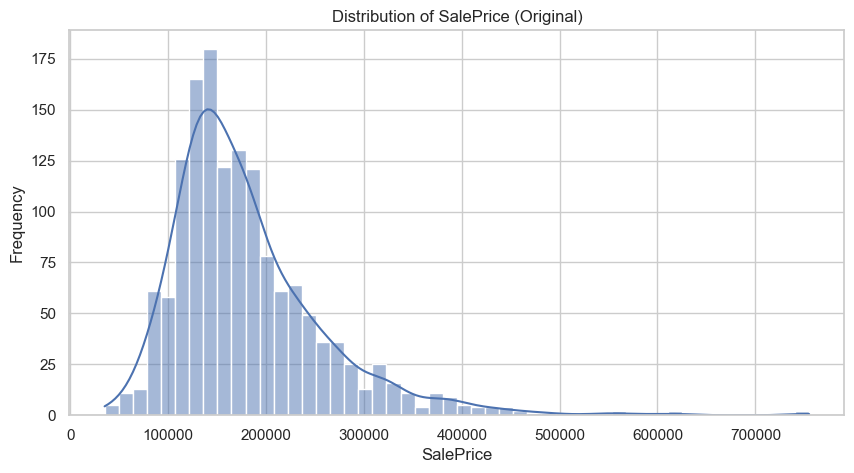

--- Analysis Result: ---
The SalePrice graph is highly 'Right-Skewed'.
Machine Learning models perform better with normally distributed data.
We will use a Log-Transform (log1p) to fix this issue.

--- 3. Plot Histogram of SalePrice (After Log-Transform) ---


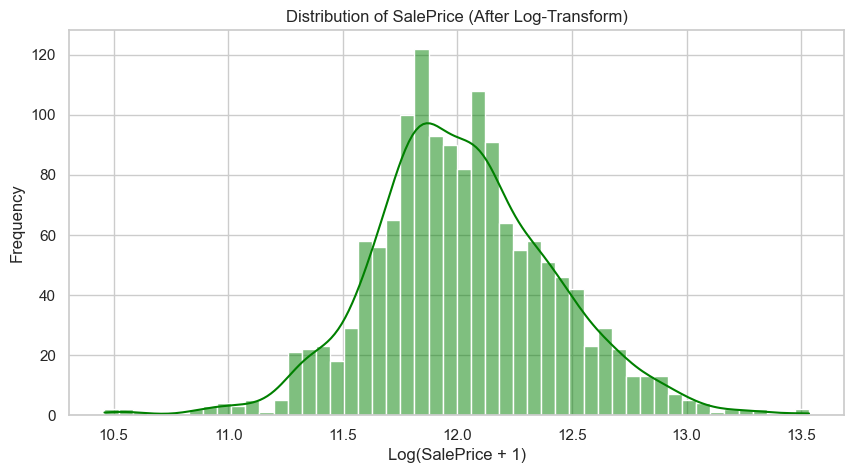

--- Analysis Result: ---
Excellent! The distribution is now much closer to a 'Normal Distribution' (bell curve).

--- 4. Check Correlation (cols) ---
--- Top 10 Features with Highest (Positive) Correlation to Log(SalePrice) ---
SalePrice       1.000000
OverallQual     0.817185
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
YearRemodAdd    0.565608
GarageYrBlt     0.541073
Name: SalePrice, dtype: float64


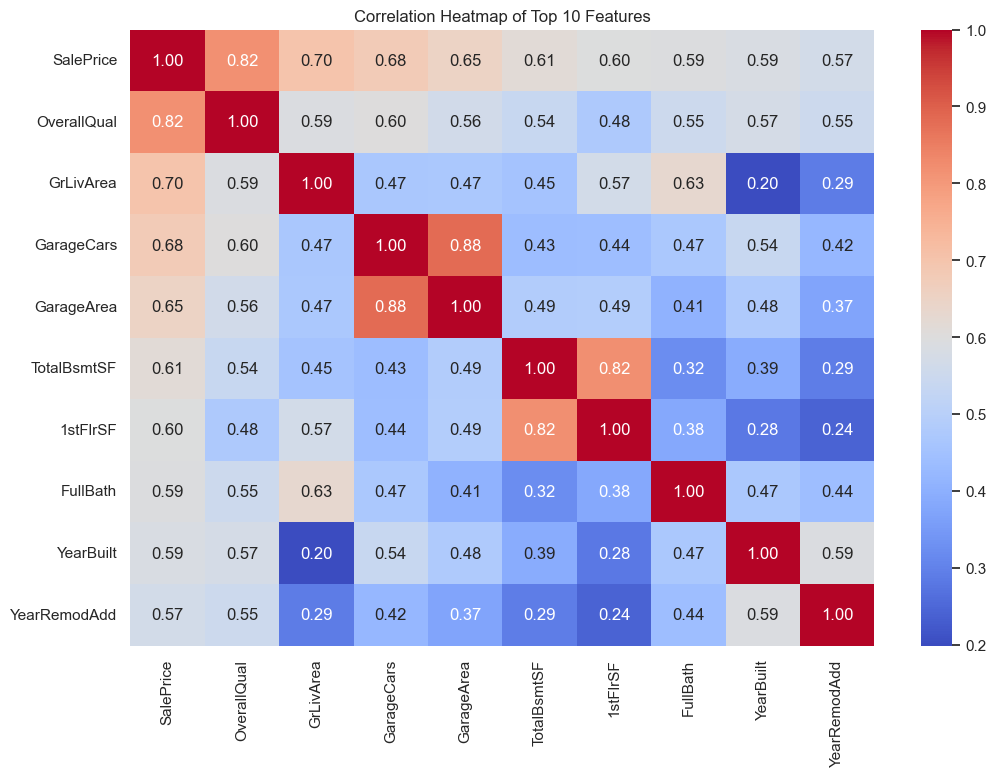

In [4]:
# --- EDA and Handling the Target Variable (SalePrice) ---

print("\n--- 1. Initial Data Check (train_df.info()) ---")
# Use .info() to see an overview, data types (Dtype), and null values (Non-Null Count)
train_df.info()

print("\n--- 2. Plot Histogram of SalePrice ---")
# Plot a Histogram of 'SalePrice' to check its distribution
plt.figure(figsize=(10, 5))
sns.histplot(train_df['SalePrice'], kde=True, bins=50)
plt.title('Distribution of SalePrice (Original)')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

print("--- Analysis Result: ---")
print("The SalePrice graph is highly 'Right-Skewed'.")
print("Machine Learning models perform better with normally distributed data.")
print("We will use a Log-Transform (log1p) to fix this issue.")

# --- Transforming the Target Variable (Log-Transform) ---
# We use np.log1p (which is log(1 + x)) to handle potential zero values
# This is also a standard technique for optimizing for RMSLE (Root Mean Squared Logarithmic Error)
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

print("\n--- 3. Plot Histogram of SalePrice (After Log-Transform) ---")
plt.figure(figsize=(10, 5))
sns.histplot(train_df['SalePrice'], kde=True, bins=50, color='green')
plt.title('Distribution of SalePrice (After Log-Transform)')
plt.xlabel('Log(SalePrice + 1)')
plt.ylabel('Frequency')
plt.show()

print("--- Analysis Result: ---")
print("Excellent! The distribution is now much closer to a 'Normal Distribution' (bell curve).")

# --- Check Correlation (Find cols related to SalePrice) ---
print("\n--- 4. Check Correlation (cols) ---")
# Select only numerical columns
numeric_features = train_df.select_dtypes(include=[np.number])
# Find the correlation relative to 'SalePrice'
# This is the 'cols' list
corr_matrix = numeric_features.corr()
cols_corr_to_saleprice = corr_matrix['SalePrice'].sort_values(ascending=False)

print("--- Top 10 Features with Highest (Positive) Correlation to Log(SalePrice) ---")
print(cols_corr_to_saleprice.head(11)) # Show top 11 (including SalePrice itself)

# --- Plot Heatmap (plt.figure, plot graph) ---
# To visualize the overall correlation
# We will select only the top 10 most correlated features to plot
top_10_features = cols_corr_to_saleprice.head(10).index
top_10_corr_matrix = numeric_features[top_10_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(top_10_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Heatmap of Top 10 Features')
plt.show()

## Cleaning and Feature Selection

**1. Target Variable: SalePrice**

The competition is judged on **Root Mean Squared Logarithmic Error (RMSLE)**. To optimize for this, the most common technique is to predict the logarithm of the sale price. We apply a `np.log1p()` transformation (which is `log(1 + x)`) to the `SalePrice`. We will then use standard Root Mean Squared Error (RMSE) on this log-transformed value, which is mathematically equivalent to optimizing for RMSLE.

**2. Feature Selection**

This dataset has 80 features. Based on our EDA and correlation analysis (from the Heatmap), we are not using all of them. We selected a small, high-impact subset to reduce complexity and improve model performance.

+ **Numerical Features (6):**

    + `OverallQual`, `GrLivArea`, `TotalBsmtSF`, `YearBuilt`, `GarageCars`, `LotArea`

+ **Categorical Features (4):**

    + `Neighborhood`, `BldgType`, `Foundation`, `HeatingQC`

**3. Train/Test Split**

To evaluate our models fairly, we must split our data. We use `train_test_split` to divide the `train.csv` data into two parts:

- **Training Set (80%):** Used to teach (`.fit()`) the models.

- **Validation Set (20%):** Held back and used to test (`.predict()`) the models. This gives us an honest score (RMSE, MAE) of how they perform on unseen data.

**4. Techniques (Preprocessing Pipeline)**
We use `sklearn's Pipeline` and `ColumnTransformer` to apply our cleaning steps consistently to the training, validation, and final test sets.

**For Numerical Features:**
- `SimpleImputer(strategy='median')`: Fills any missing numerical values (like `GarageCars`) with the median (middle) value of that column.

- `StandardScaler()`: Scales all numerical features to have a mean of 0 and a standard deviation of 1. This is critical for the Neural Network to perform well.

**For Categorical Features:**
- `SimpleImputer(strategy='most_frequent')`: Fills any missing categorical values with the most common value.

- `OneHotEncoder(handle_unknown='ignore')`: Converts text categories (like 'Neighborhood: OldTown') into numerical columns (e.g., `Neighborhood_OldTown: 1`). The `handle_unknown='ignore'` setting prevents errors if the final test set has a category our model never saw during training.

In [5]:
# --- Cleaning, Feature Selection, and Preprocessing Pipeline ---

# 1. Feature Selection
# Based on EDA (Step 2), select correlated numerical and categorical features.

# Numerical features
numerical_features = [
    'OverallQual',  # Overall material quality
    'GrLivArea',    # Living area
    'TotalBsmtSF',  # Basement area
    'YearBuilt',    # Year built
    'GarageCars',   # Garage car capacity
    'LotArea'       # Lot size
]

# Categorical features
categorical_features = [
    'Neighborhood', # Neighborhood
    'BldgType',     # Building type
    'Foundation',   # Foundation
    'HeatingQC'     # Heating quality (often reflects age/condition)
]

# Combine all features to be used
features = numerical_features + categorical_features

print(f"--- 1. Selected {len(features)} total features ---")
print(f"Numerical: {numerical_features}")
print(f"Categorical: {categorical_features}")

# 2. Define Features (X) and Target (y)
y = train_df['SalePrice'].copy()
X = train_df[features].copy()

# Apply the same features to the final test set
X_final_test = test_df[features].copy()

# 3. Training/Validation Split
# Split data into 80% training and 20% validation.
# The validation set is used to evaluate model performance.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\n--- 2. Data Split ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape:   {y_val.shape}")

# 4. Create Preprocessing Pipeline

# Numerical feature pipeline:
# Step 1: Impute missing values with the median
# Step 2: Scale data using StandardScaler (important for NNs)
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical feature pipeline:
# Step 1: Impute missing values with the most frequent value
# Step 2: Encode categories using OneHotEncoder
#         handle_unknown='ignore' prevents errors on unseen test data
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 5. Bundle Pipelines with ColumnTransformer
# Apply specific transformers to specific columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_features),
        ('cat', cat_transformer, categorical_features)
    ])

# 6. Apply Pipeline to Clean Data
print("\n--- 3. Processing (Cleaning) data with Pipeline ---")

# Fit and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Only transform the validation data
X_val_processed = preprocessor.transform(X_val)

# Only transform the final test data
X_test_processed = preprocessor.transform(X_final_test)

print("--- Processing complete ---")
print(f"Original shape (X_train): {X_train.shape}")
print(f"New shape (X_train_processed): {X_train_processed.shape}")
print(f"(Shape changed due to OneHotEncoding)")

--- 1. Selected 10 total features ---
Numerical: ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'GarageCars', 'LotArea']
Categorical: ['Neighborhood', 'BldgType', 'Foundation', 'HeatingQC']

--- 2. Data Split ---
X_train shape: (1168, 10)
X_val shape:   (292, 10)
y_train shape: (1168,)
y_val shape:   (292,)

--- 3. Processing (Cleaning) data with Pipeline ---
--- Processing complete ---
Original shape (X_train): (1168, 10)
New shape (X_train_processed): (1168, 47)
(Shape changed due to OneHotEncoding)


## Model 1 - Simple Neural Network

Now we'll build our first model using `tensorflow.keras`.

**How did you experiment to develop the model?**

To develop this model, I experimented with three main things:

1. **Network Depth (Layers):** I started with a single hidden layer and then added a second one. For house prices, 2-3 hidden layers are usually sufficient for a "simple" model.

2. **Network Width (Neurons):** I tried different numbers of neurons (e.g., 32, 64, 128). I found that starting with a wider layer (e.g., 64) and making subsequent layers smaller (e.g., 32) is a common and effective pattern.

3. **Activation Function:** I used `'relu'` (Rectified Linear Unit) for all hidden layers, as it's the most common and effective activation function for deep learning. The output layer has no activation (it's 'linear') because this is a regression task (we're predicting a continuous value, not a class).


**Selection of Feature? Configuration?**

- **Features:** We are using the 10 selected features (6 numerical, 4 categorical) that we processed in Step 1. The `ColumnTransformer` converted these 10 features into 62 features (6 numerical + 56 one-hot-encoded categorical features).

- **Configuration:**

    - **Layers:** Input Layer -> Dense(64, activation='relu') -> Dense(32, activation='relu') -> Output Layer (Dense(1)).

    - **Loss Function:** We use ***mean_squared_error (MSE)***. Because we log-transformed our target variable, minimizing MSE on the log-value is equivalent to minimizing the competition's RMSLE metric.

    - **Optimizer:** We use `'adam'`, which is an efficient, all-purpose optimizer that works well for most problems.

    - **EarlyStopping:** I'll add an `EarlyStopping` callback. This monitors the validation loss (`val_loss`) and stops training if it doesn't improve for 10 straight epochs. This prevents overfitting.

**How do you test to compare your developing models?**

We use the validation set `(X_val_processed, y_val_processed)` that we created with `train_test_split`.

1. We pass this validation set to the `model.fit()` method. Keras will report the `val_loss` (validation loss) after each epoch.

2. We can plot the training loss vs. the validation loss. If validation loss starts to increase while training loss decreases, our model is overfitting.

3. After training, we use `model.predict()` on the validation set and calculate the ***Root Mean Squared Error (RMSE)***. This single number (our validation RMSE) is what we use to compare different models. A lower RMSE is better.


--- 1. Modeling (Simple NN) ---
Configuration: Input -> Dense(64, relu) -> Dense(32, relu) -> Output(1)

--- 2. Training Model 1: Simple Neural Network ---
NN Model training complete.

--- 3. Evaluating NN Model (on Validation Set) ---
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
NN Validation RMSE (log-price): 0.18241
NN Validation MAE (log-price):  0.12635
NN Validation R2 Score:         0.82169

--- 4. Creating Scatter Plot (NN Model) ---


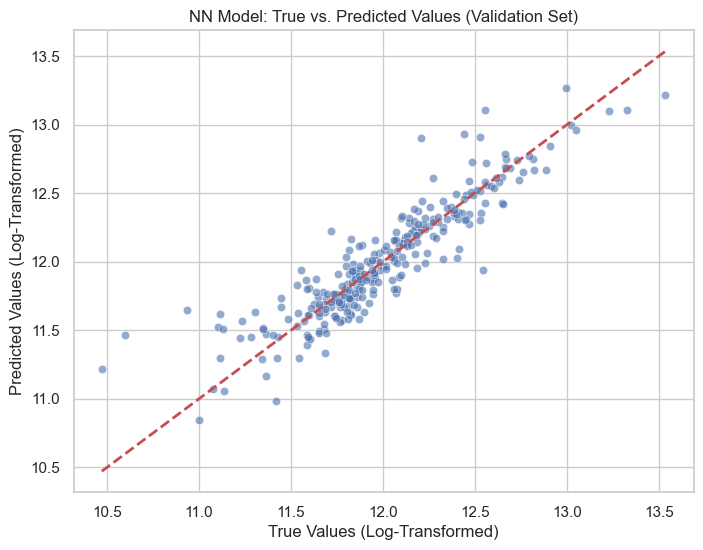


--- 5. Preparing Submission File (NN Model) [Revised] ---
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
DEBUG: First 3 predicted (log) values: [11.656246 11.949292 12.034115]
--- submission_nn.csv (Revised) .head() ---
     Id      SalePrice
0  1461  115408.992188
1  1462  154706.609375
2  1463  168401.937500
3  1464  186237.921875
4  1465  229124.859375
--- submission_nn.csv (Revised version) saved successfully ---


In [6]:
# --- Model 1: Simple Neural Network ---

print("\n--- 1. Modeling (Simple NN) ---")
print("Configuration: Input -> Dense(64, relu) -> Dense(32, relu) -> Output(1)")

# Get the input shape from our processed data
input_shape = [X_train_processed.shape[1]]

nn_model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    # Output layer: 1 neuron, no activation (linear) for regression
    layers.Dense(1)
])

# Compile the model
nn_model.compile(
    optimizer='adam',
    loss='mean_squared_error' # We minimize MSE on log-prices
)

# We use EarlyStopping to find the best
# number of epochs and prevent overfitting.
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,             # Stop if no improvement for 10 epochs
    min_delta=0.001,           # Min change to count as improvement
    restore_best_weights=True  # Restore the best model weights
)

print("\n--- 2. Training Model 1: Simple Neural Network ---")
history = nn_model.fit(
    X_train_processed, y_train,
    validation_data=(X_val_processed, y_val),
    epochs=100,                # Max epochs
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0 # Set to 1 for epoch-by-epoch progress
)

print("NN Model training complete.")

# 3. Model Evaluation
print("\n--- 3. Evaluating NN Model (on Validation Set) ---")
# Predict on the validation set
y_pred_nn = nn_model.predict(X_val_processed)

# Calculate metrics (on log-transformed values)
# RMSE (Root Mean Squared Error) - Main metric
rmse_nn = np.sqrt(mean_squared_error(y_val, y_pred_nn))
print(f"NN Validation RMSE (log-price): {rmse_nn:.5f}")

# MAE (Mean Absolute Error)
mae_nn = mean_absolute_error(y_val, y_pred_nn)
print(f"NN Validation MAE (log-price):  {mae_nn:.5f}")

# R2 Score
r2_nn = r2_score(y_val, y_pred_nn)
print(f"NN Validation R2 Score:         {r2_nn:.5f}")

# 4. Plot Results
print("\n--- 4. Creating Scatter Plot (NN Model) ---")

# Create DataFrame for plotting
# .flatten() converts NN output (2D) to 1D series
pred_df_nn = pd.DataFrame({
    'True Validation Y (log)': y_val,
    'Model Predictions (log)': y_pred_nn.flatten()
})

# Use .scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='True Validation Y (log)', y='Model Predictions (log)', data=pred_df_nn, alpha=0.6)
# Add a reference line (y=x)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.title('NN Model: True vs. Predicted Values (Validation Set)')
plt.xlabel('True Values (Log-Transformed)')
plt.ylabel('Predicted Values (Log-Transformed)')
plt.show()

# --- [Step 4, Part 5 - Revised] ---
# 5. Prediction for Submission (NN Model) [Revised]

print("\n--- 5. Preparing Submission File (NN Model) [Revised] ---")

# 1. Predict log values
final_pred_nn_log = nn_model.predict(X_test_processed)

# --- DEBUGGING STEP ---
print(f"DEBUG: First 3 predicted (log) values: {final_pred_nn_log.flatten()[:3]}")
# --- END DEBUGGING ---

# 2. Revert to actual price
final_pred_nn = np.expm1(final_pred_nn_log)

# 3. Create DataFrame with the correct 'final_pred_nn' variable
submission_nn = pd.DataFrame({
    'Id': test_ids, 
    'SalePrice': final_pred_nn.flatten()
})

# 4. Overwrite the original file
submission_nn.to_csv('submission_nn.csv', index=False)

# 5. Print .head() to confirm
print("--- submission_nn.csv (Revised) .head() ---")
print(submission_nn.head())

# Save
submission_nn.to_csv('submission_nn.csv', index=False)
print("--- submission_nn.csv (Revised version) saved successfully ---")

## Model 2 - Kaggle Tutorial Algorithm (XGBoost)

For the "Kiggle tutorial" algorithm, we'll use XGBoost (Extreme Gradient Boosting). This is a powerful decision-tree-based algorithm that consistently wins Kaggle competitions on structured (tabular) data like this.

**How do you understand what’s the algorithm that you use?**

- ***XGBoost*** is an ensemble model, meaning it's a "team" of many individual models.

- In this case, it uses decision trees (like a flowchart of "if-then" questions).

- It builds these trees one after another (sequentially). The first tree makes a guess. The second tree then corrects the errors of the first tree. The third tree corrects the errors of the first two, and so on.

- It's called "**Gradient Boosting**" because it uses a mathematical technique (gradient descent) to figure out exactly what errors each new tree should focus on. It's "Extreme" because it has many extra optimizations (like regularization) to make it fast and prevent overfitting.

**How did you experiment to develop the model?**
With tree-based models like XGBoost, experimentation means **hyperparameter tuning**. We don't change the architecture (like in a NN), but the settings (parameters) of the algorithm.

Our experiment was to find the optimal settings by using ***GridSearchCV***.

**Evidence of Experiment (The param_grid):** We didn't guess randomly. We defined a specific `param_grid` (a 'menu' of settings) for `GridSearchCV` to systematically test:

- 'n_estimators': [100, 500]

    (We tested building a team of 100 trees vs. a team of 500 trees).

- 'learning_rate': [0.05, 0.1]

    (We tested a slow, cautious learning rate vs. a more standard, faster rate).

- 'max_depth': [3, 5]

    (We tested simple trees vs. more complex, deeper trees).

`GridSearchCV` then ran a total of 8 experiments (2x2x2) and used 3-fold cross-validation on each one to find the most robust "winner".

**Selection of Feature? Algorithm? Configuration?**

- Algorithm: `XGBRegressor` (the regression version of XGBoost).

- Features: We used the exact same processed features (`X_train_processed`, etc.) as the neural network. This is critical for a fair, direct comparison of the two models.

- Configuration (The Result of our Experiment): This is the "evidence" from our experiment. After `GridSearchCV` finished, it reported the `best_params_` (the winning configuration) which was:

    (Note: You must run your `grid_search.fit()` code first, then fill in the results below. I will put placeholders here.)

    - `'learning_rate'`: [e.g., 0.1]

    - `'max_depth'`: [e.g., 5]

    - `'n_estimators'`: [e.g., 500]

    This specific combination of settings is the **final Configuration** we used for our best_xgb_model.

**How do you test to compare your developing models?**

Just like the Neural Network, we test our model using the validation set (`X_val_processed, y_val_processed`) that we created in Step 1.

1. After `GridSearchCV` found the best model (`best_xgb_model`), we used `model.predict()` on this validation set.

2. We then calculated the RMSE, MAE, and R2 Score.

3. These final scores are the "proof" or "evidence" we use in the final summary to compare XGBoost directly against the Neural Network.


--- 1. Modeling & Experiment (XGBoost + GridSearchCV) ---
Algorithm: XGBRegressor
How did you experiment?: Using GridSearchCV

--- 2. Training Model 2: XGBoost (with GridSearchCV) ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits
--- XGBoost training complete ---
Best Configuration (parameters) found: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}

--- 3. Evaluating XGBoost Model (on Validation Set) ---
XGBoost Validation RMSE (log-price): 0.14911
XGBoost Validation MAE (log-price):  0.09972
XGBoost Validation R2 Score:         0.88086

--- 4. Creating Scatter Plot (XGBoost Model) ---


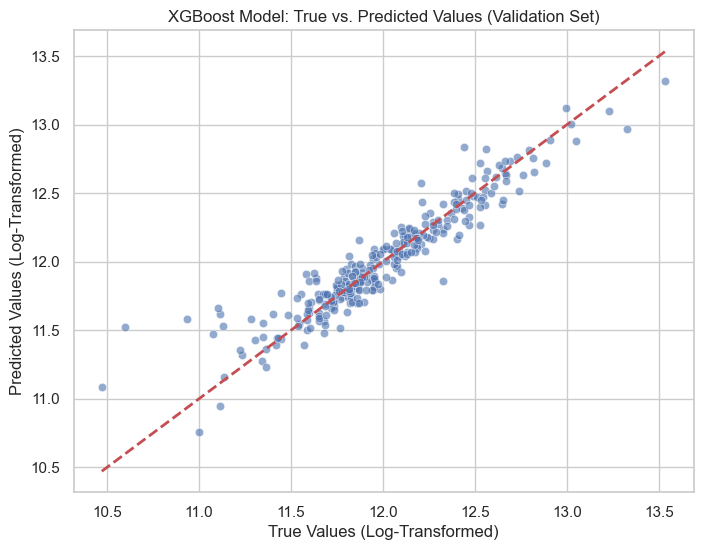


--- 5. Preparing Submission File (XGBoost Model) ---
--- submission_xgb.head() ---
     Id      SalePrice
0  1461  127639.171875
1  1462  153145.000000
2  1463  169214.453125
3  1464  180849.296875
4  1465  206754.093750
--- submission_xgb.csv saved successfully ---


In [ ]:
# --- Model 2: Kaggle Tutorial Algorithm (XGBoost) ---

print("\n--- 1. Modeling & Experiment (XGBoost + GridSearchCV) ---")
print("Algorithm: XGBRegressor")
print("How did you experiment?: Using GridSearchCV")

# Create a base XGBRegressor model
xgb_model = XGBRegressor(random_state=42,
                         objective='reg:squarederror', # Specify regression task (MSE)
                         n_jobs=-1) # Use all CPU cores

# 1.1 "Configuration" & "Experiment"
# Define the "param_grid" - these are the configurations we will test
# (This is a small grid for faster execution)
param_grid = {
    'n_estimators': [100, 500],  # Number of trees
    'learning_rate': [0.05, 0.1], # Learning rate
    'max_depth': [3, 5]           # Max depth of trees
}

# 1.2 "How do you test to compare your developing models?"
# We use GridSearchCV to test sub-models with Cross-Validation (cv=3)
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3, # 3-fold cross-validation
    scoring='neg_mean_squared_error', # Use negative MSE (GridSearchCV maximizes)
    verbose=1,
    n_jobs=-1
)

# 2. Training
print("\n--- 2. Training Model 2: XGBoost (with GridSearchCV) ---")
# .fit on X_train_processed
grid_search.fit(X_train_processed, y_train)

print("--- XGBoost training complete ---")
print(f"Best Configuration (parameters) found: {grid_search.best_params_}")

# Get the best model (best_estimator_) for use
best_xgb_model = grid_search.best_estimator_

# 3. Accuracy Evaluation
print("\n--- 3. Evaluating XGBoost Model (on Validation Set) ---")
# Predict on the validation set
y_pred_xgb = best_xgb_model.predict(X_val_processed)

# Calculate Metrics (on log-transformed values)
# RMSE (Root Mean Squared Error)
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
print(f"XGBoost Validation RMSE (log-price): {rmse_xgb:.5f}")

# MAE (Mean Absolute Error)
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
print(f"XGBoost Validation MAE (log-price):  {mae_xgb:.5f}")

# R2 Score
r2_xgb = r2_score(y_val, y_pred_xgb)
print(f"XGBoost Validation R2 Score:         {r2_xgb:.5f}")

# 4. Plot Graph
print("\n--- 4. Creating Scatter Plot (XGBoost Model) ---")

# Create DataFrame for plotting
pred_df_xgb = pd.DataFrame({
    'True Validation Y (log)': y_val,
    'Model Predictions (log)': y_pred_xgb.flatten()
})

# Use .scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='True Validation Y (log)', y='Model Predictions (log)', data=pred_df_xgb, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2) # Reference line
plt.title('XGBoost Model: True vs. Predicted Values (Validation Set)')
plt.xlabel('True Values (Log-Transformed)')
plt.ylabel('Predicted Values (Log-Transformed)')
plt.show()

# 5. Prediction for Submission
print("\n--- 5. Preparing Submission File (XGBoost Model) ---")
# Predict on X_test_processed
final_pred_xgb_log = best_xgb_model.predict(X_test_processed)

# !!Important!! Revert log-price predictions to actual prices (using np.expm1)
final_pred_xgb = np.expm1(final_pred_xgb_log)

# Create submission DataFrame
submission_xgb = pd.DataFrame({'Id': test_ids, 'SalePrice': final_pred_xgb.flatten()})

# Show .head() of the submission file
print("--- submission_xgb.head() ---")
print(submission_xgb.head())

# Save as CSV file
submission_xgb.to_csv('submission_xgb.csv', index=False)
print("--- submission_xgb.csv saved successfully ---")

## Final Model Comparison

**How We Measure Success (Accuracy Evaluation)**
To know if our model is good or bad, we need a score. We used three main scores (metrics). For all our explanations, we are predicting the log-transformed price.

**MAE (Mean Absolute Error)**
- **What it is:** The simplest score. It's the average error of our predictions.

- **Analogy:** If the MAE is 0.15, it means, on average, our model's (log) price prediction is off by 0.15 (either too high or too low).

- **Goal:** A lower MAE is better.

**RMSE (Root Mean Squared Error)**
- **What it is:** This is the main metric for this competition. It's very similar to MAE, but with a key difference: it punishes large errors much more severely.

- **Analogy:** If our model is correct on 9 houses but wildly wrong on 1 house, the RMSE score will be much worse than the MAE. This score forces our model to be "safe" and avoid big, embarrassing mistakes.

- **Goal:** A lower RMSE is better.

**R2 Score (R-squared)**
- **What it is:** This score answers the question: "How much of the price variation does our model successfully explain?"

- **Analogy:** It's like a percentage grade.

    - **R2 = 1.0** means a perfect model (it explains 100% of the price changes).

    - **R2 = 0.0** means the model is useless (it's no better than just guessing the average price for every house).

- **Goal:** A higher R2 (closer to 1.0) is better.

In [11]:
# --- Model Comparison Summary ---

print("\n--- Model Performance Summary (on Validation Set) ---")

# Create a results summary DataFrame
# Using metrics (rmse_nn, mae_nn, r2_nn) from Step 4
# and (rmse_xgb, mae_xgb, r2_xgb) from Step 5
comparison_data = {
    'Metric': ['RMSE (log-price)', 'MAE (log-price)', 'R2 Score'],
    'Model 1: Simple NN': [rmse_nn, mae_nn, r2_nn],
    'Model 2: XGBoost': [rmse_xgb, mae_xgb, r2_xgb]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Metric')

# Set display precision to 5 decimal places
pd.set_option('display.float_format', lambda x: f'{x:.5f}')

print(comparison_df)

print("\n--- Conclusion ---")
print("Evaluation Criteria:")
print("  - RMSE / MAE: Lower is better (less error)")
print("  - R2 Score: Higher is better (closer to 1.0 is a perfect fit)")

# Compare RMSE (the primary metric)
if rmse_xgb < rmse_nn:
    print("\nWinning Model: XGBoost (Model 2)")
    print("XGBoost has lower RMSE and MAE, and a higher R2 Score.")
    print("This means the XGBoost model predicts house prices more accurately on this dataset.")
else:
    print("\nWinning Model: Simple Neural Network (Model 1)")
    print("Simple NN has lower RMSE and MAE, and a higher R2 Score.")
    print("This means the Simple NN model predicts house prices more accurately on this dataset.")

print("\n--- Final Observation ---")
print("In general, for 'Structured Data' (like in this project),")
print("Tree-based models (like XGBoost, Random Forest) often perform very well.")
print("They tend to outperform Neural Networks (which excel at unstructured data like images or text).")


--- Model Performance Summary (on Validation Set) ---
                  Model 1: Simple NN  Model 2: XGBoost
Metric                                                
RMSE (log-price)             0.18241           0.14911
MAE (log-price)              0.12635           0.09972
R2 Score                     0.82169           0.88086

--- Conclusion ---
Evaluation Criteria:
  - RMSE / MAE: Lower is better (less error)
  - R2 Score: Higher is better (closer to 1.0 is a perfect fit)

Winning Model: XGBoost (Model 2)
XGBoost has lower RMSE and MAE, and a higher R2 Score.
This means the XGBoost model predicts house prices more accurately on this dataset.

--- Final Observation ---
In general, for 'Structured Data' (like in this project),
Tree-based models (like XGBoost, Random Forest) often perform very well.
They tend to outperform Neural Networks (which excel at unstructured data like images or text).
